# Epidemic spread over the flights network

David Diener (19-733-179)
Kevin Kindler (15-922-529)
Layla Husselman (17-733-130)
Rafael Dubach (18-755-140)


## Dataset

https://networks.skewed.de/net/openflights 

https://ipywidgets.readthedocs.io/en/stable/

| **Name**              | **Description**                                                                                                                                                                                                                        |
|-----------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Airport ID            | Unique OpenFlights identifier for this airport.                                                                                                                                                                                        |
| Name                  | Name of airport. May or may not contain the City name.                                                                                                                                                                                 |
| City                  | Main city served by airport. May be spelled differently from Name.                                                                                                                                                                     |
| Country               | Country or territory where airport is located. See Countries to cross-reference to ISO 3166-1 codes.                                                                                                                                   |
| IATA                  | 3-letter IATA code. Null if not assigned/unknown.                                                                                                                                                                                      |
| ICAO                  | 4-letter ICAO code. Null if not assigned.                                                                                                                                                                                              |
| -                     | -                                                                                                                                                                                                                                      |
| Latitude              | Decimal degrees, usually to six significant digits. Negative is South, positive is North.                                                                                                                                              |
| Longitude             | Decimal degrees, usually to six significant digits. Negative is West, positive is East.                                                                                                                                                |
| Altitude              | In feet.                                                                                                                                                                                                                               |
| Timezone              | Hours offset from UTC. Fractional hours are expressed as decimals, eg. India is 5.5.                                                                                                                                                   |
| DST                   | Daylight savings time. One of E (Europe), A (US/Canada), S (South America), O (Australia), Z (New Zealand), N (None) or U (Unknown). See also: Help: Time                                                                              |
| Tz database time zone | Timezone in "tz" (Olson) format, eg. "America/Los_Angeles".                                                                                                                                                                            |
| Type                  | Type of the airport. Value "airport" for air terminals, "station" for train stations, "port" for ferry terminals and "unknown" if not known. In airports.csv, only type=airport is included.                                           |
| Source                | Source of this data. "OurAirports" for data sourced from OurAirports, "Legacy" for old data not matched to OurAirports (mostly DAFIF), "User" for unverified user contributions. In airports.csv, only source=OurAirports is included. |


# Importing the Data

##### Imports

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
import collections
from IPython.display import Image
import matplotlib as mpl

# Worldmap
from libpysal import weights, examples
from libpysal.cg import voronoi_frames
#from contextily import add_basemap
#import geopandas
#from shapely.geometry import Point
#import fiona
#import cartopy.crs as ccrs


## Openflights — Openflights airport network
Openflights airport network is a network of regularly occurring flights among airports worldwide, extracted from the openflights.org dataset.

**Nodes:**

* Represent airports
* example node:

| **key**     | **value**  |
|-------------|------------|
| # index     | 0
| id          |1  
| name        |Goroka Airport
| city        |Goroka
| country        |Papua New Guinea
| IATA/FAA        |GKA
| ICAO        |AYGA
| latitude        |-6.08169
| longitude        |145.391998
| altitude        |5282
| timezone        |10.0
| DST        |U
| _pos        |array([6.29268027, 1.37900375])





**Edges:** 
* Have a direction (i, j) which indicates a regularly occurring commercial flight by a particular airline from airport i to airport j        
* Multiple edges may exist between a pair of airpots if multiple airlines offer that flight, or if one airline offers multiple such flights each day.
* It is important to notice that a flight in this dataset is defined as a normally regularly occuring flight identified by its flight number (e.g., AF331), not individual flights (e.g., AF331 on June 14 2015) -> Retrieved from http://konect.cc/networks/openflights/.
* example edge:

| **key**     | **value**  |
|-------------|------------|
| # source     | 0
| target          |2  
| distance        |124.520121
| airline        |CG
| airline_code        |1308
| codeshare        |0
| equipment        |DH8 DHT
| stops        |0

           
                     

In [3]:
edges = pd.read_csv('edges.csv',sep=',')
nodes = pd.read_csv('nodes.csv',sep=',')
#print(edges.head())

### Creating the directed graph G of the network
Here are we creating a directed graph of the network.
* We assign a directed edge from airport i to airport j if an airport offers that flight.
* Each edge has a weight w assigned. The weight tells how many regularly occurring flights there are from all airlines from airport i to airport j.

In [4]:
G = nx.DiGraph()
G.add_nodes_from(nodes['# index'])

#g.add_edges_from(edges['# source'],edges['target'], bipartite=0)

for index ,edge in edges.iterrows():
    if G.has_edge(edge['# source'], edge[' target']):
        G[edge['# source']][edge[' target']]['weight'] += 1
    else:
        G.add_edge(edge['# source'], edge[' target'], weight=1)
    #g.add_edges_from([(b['# source'], b[' target'])])
    #g.add_weighted_edges_from([(b['# source'], b[' target'], b[' weight'])])

### Creating the undirected graph GU of the network
Here are we creating a undirected graph of the network.
* We assign an undirected edge between the airports i and j if the airport i offers a flight to airport j or airport j offers a flight to airport i.
* Each edge has a weight w assigned. The weight tells how many regularly occurring flights there are from all airlines between airport i and airport j.

In [5]:
GU = nx.Graph()
GU.add_nodes_from(nodes['# index'])

#g.add_edges_from(edges['# source'],edges['target'], bipartite=0)

for index, edge in edges.iterrows():
    if GU.has_edge(edge['# source'], edge[' target']):
        GU[edge['# source']][edge[' target']]['weight'] += 1
    else:
        GU.add_edge(edge['# source'], edge[' target'], weight=1)
    #g.add_edges_from([(b['# source'], b[' target'])])
    #g.add_weighted_edges_from([(b['# source'], b[' target'], b[' weight'])])

### Creating an Airport Dictionary of the network
* The dictionary is of the form:       airport_dict{index: 'airport_name', ...}

In [6]:
airport_dict = {}
for node in nodes.iterrows():
    airport_dict[node[1]['# index']] = node[1][' name']

In [7]:
G[4][0]["weight"]
G.get_edge_data(4,0)

{'weight': 2}

In [8]:
print(nx.average_clustering(G))

0.4782853255477226


# Calculations

# Analysing the Directed Graph G

#### Graph connectivity

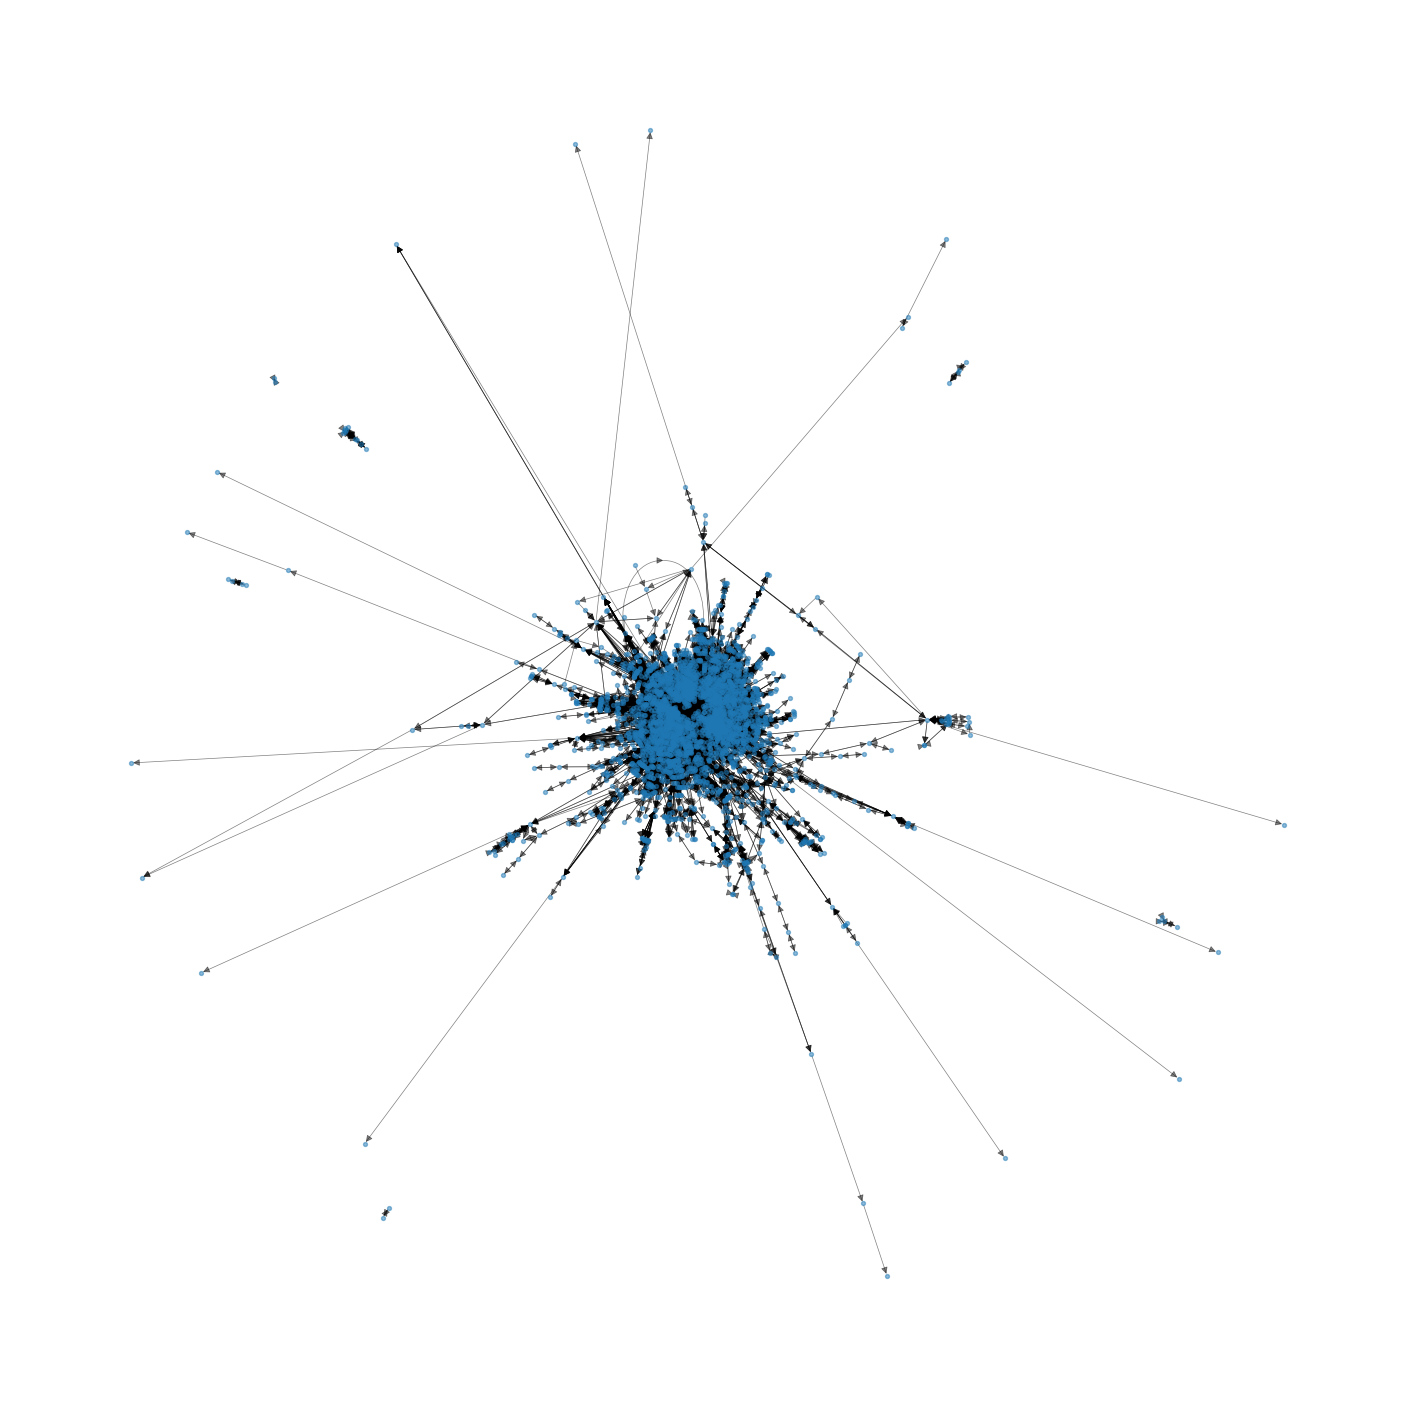

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(18, 18))
nx.draw_networkx(G, ax=ax, node_size=8, alpha=.5, width=.5, with_labels=False)
ax.set_axis_off()

### Assortativity of the directed graph
* Describs the overall connectivity between the nodes
* Is the Pearson correlation coefficient of degree between pairs of linked nodes

In [10]:
print(nx.degree_assortativity_coefficient(G))

-0.019185790136906775


The assortativity coefficient lays almost exactly between -1 and 1. This means that the network is not assortative nor dissortative but inbetween. This means that some nodes are well connected while others are not well connected.

### Global properties of the directed graph

In [11]:
# Basic calculations
degree = nx.degree(G)
degree_hist = nx.degree_histogram(G)
density = nx.density(G)
average_clustering = nx.average_clustering(G)
num_nodes = nx.number_of_nodes(G)
num_edges = nx.number_of_edges(G)
average_degree = sum(degree_hist) / len(degree_hist)
max_weight = max([G[u][v]['weight'] for u,v in G.edges()])

In [12]:
print("Directed graph")
print("------------------------------------------------------")
print(f"Density:                          {density}")
print(f"Average clustering                {average_clustering}")
print(f"Number of nodes:                  {num_nodes}")
print(f"Number of edges:                  {num_edges}")
print(f"Average degree:                   {average_degree}")
print(f"Max weight:                       {max_weight}")

Directed graph
------------------------------------------------------
Density:                          0.003573980238572647
Average clustering                0.4782853255477226
Number of nodes:                  3214
Number of edges:                  36907
Average degree:                   6.7238493723849375
Max weight:                       20


#### The most popular routes
We searched for the edges with the largest weight to find the most popular routes

In [13]:
# 1885, 1809, distance, 3378, 1, E75 CR7, 0
#print(max(dict(G.edges).items(), key=lambda x: x[1]['weight']))
max_edge = max(dict(G.edges).items(), key=lambda x: x[1]['weight'])
source_airport = airport_dict[max_edge[0][0]]
target_airport = airport_dict[max_edge[0][1]]
flights = max_edge[1]['weight']
print("The most popular route is from {} to {} with {} flights".format(source_airport, target_airport, flights))

The most popular route is from Chicago O'Hare International Airport to Hartsfield Jackson Atlanta International Airport with 20 flights


In [14]:
# 1885, 1809, distance, 3378, 1, E75 CR7, 0
print("The most popular routes are:")
max_edge = sorted(dict(G.edges).items(), key=lambda x: x[1]['weight'], reverse=True)
for i in range(10):
    source_airport = airport_dict[max_edge[i][0][0]]
    target_airport = airport_dict[max_edge[i][0][1]]
    flights = max_edge[i][1]['weight']

    print("{}. From {} to {} with {} flights".format(i+1,source_airport, target_airport, flights))

The most popular routes are:
1. From Chicago O'Hare International Airport to Hartsfield Jackson Atlanta International Airport with 20 flights
2. From Hartsfield Jackson Atlanta International Airport to Chicago O'Hare International Airport with 19 flights
3. From Phuket International Airport to Suvarnabhumi Airport with 13 flights
4. From Chicago O'Hare International Airport to Louis Armstrong New Orleans International Airport with 13 flights
5. From London Heathrow Airport to John F Kennedy International Airport with 12 flights
6. From Abu Dhabi International Airport to Muscat International Airport with 12 flights
7. From Hong Kong International Airport to Suvarnabhumi Airport with 12 flights
8. From Guangzhou Baiyun International Airport to Hangzhou Xiaoshan International Airport with 12 flights
9. From Miami International Airport to Hartsfield Jackson Atlanta International Airport with 12 flights
10. From Hartsfield Jackson Atlanta International Airport to Miami International Airport

### The most popular airports in terms of degree distribution

For every node we calculate:
* the in-degree
* the out-degree
and show the histogram

The 10 airports with the highest in-degree are:
1. Frankfurt am Main Airport with 238 flights landing
2. Charles de Gaulle International Airport with 233 flights landing
3. Amsterdam Airport Schiphol with 231 flights landing
4. Atatürk International Airport with 227 flights landing
5. Hartsfield Jackson Atlanta International Airport with 216 flights landing
6. Beijing Capital International Airport with 204 flights landing
7. Chicago O'Hare International Airport with 203 flights landing
8. Munich Airport with 189 flights landing
9. Domodedovo International Airport with 188 flights landing
10. Dallas Fort Worth International Airport with 185 flights landing


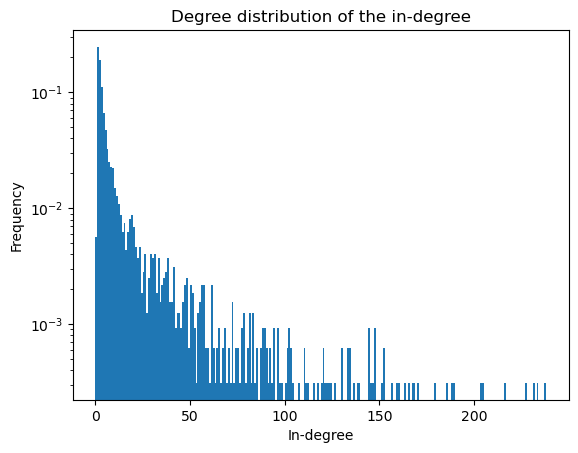


The 10 airports with the highest out-degree are:
1. Frankfurt am Main Airport with 239 flights taking off
2. Charles de Gaulle International Airport with 237 flights taking off
3. Amsterdam Airport Schiphol with 232 flights taking off
4. Atatürk International Airport with 224 flights taking off
5. Hartsfield Jackson Atlanta International Airport with 217 flights taking off
6. Chicago O'Hare International Airport with 206 flights taking off
7. Beijing Capital International Airport with 204 flights taking off
8. Munich Airport with 191 flights taking off
9. Dallas Fort Worth International Airport with 187 flights taking off
10. Domodedovo International Airport with 187 flights taking off


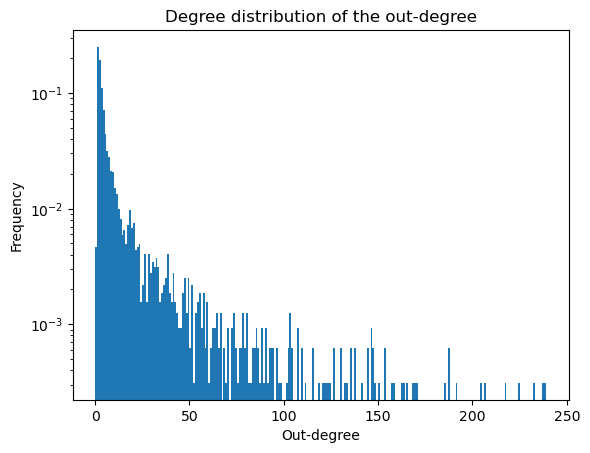

In [15]:
# the in-degree distribution
in_degree = G.in_degree()
# show the 10 with the highest in-degree
ten_highest_in_degrees = sorted(in_degree, key=lambda x: x[1], reverse=True)[:10]
print("The 10 airports with the highest in-degree are:")
for i in range(10):
    print("{}. {} with {} flights landing".format(i+1,airport_dict[ten_highest_in_degrees[i][0]], ten_highest_in_degrees[i][1]))
in_degree = [in_degree[i] for i in range(len(in_degree))]
my_bins = np.linspace(0, max(in_degree), max(in_degree)+1)
plt.hist(in_degree, bins=my_bins, density=True)
plt.yscale('log')
plt.xlabel('In-degree')
plt.ylabel('Frequency')
plt.title('Degree distribution of the in-degree')
plt.show()
print("")

# the out-degree distribution
out_degree = G.out_degree()
# show the 10 with the highest out-degree
ten_highest_out_degrees = sorted(out_degree, key=lambda x: x[1], reverse=True)[:10]
print("The 10 airports with the highest out-degree are:")
for i in range(10):
    print("{}. {} with {} flights taking off".format(i+1,airport_dict[ten_highest_out_degrees[i][0]], ten_highest_out_degrees[i][1]))
out_degree = [out_degree[i] for i in range(len(out_degree))]
my_bins = np.linspace(0, max(out_degree), max(out_degree)+1)
plt.hist(out_degree, bins=my_bins, density=True)
plt.yscale('log')
plt.xlabel('Out-degree')
plt.ylabel('Frequency')
plt.title('Degree distribution of the out-degree')
plt.show()
print("")



Logically, the in-degree and the out-degree of an airport are pretty much the same. Because an airline that arrives at an airport with a flight naturally wants to continue flying with this aircraft and therefore also has a flight that leaves the airport.

So it is no surprise that the 10 airports with the most arrival flights are also the 10 airports with the most departure flights, namely:
Frankfurt am Main, Charles de Gaulle International Airport, Amsterdam Airport Schiphol, Atatürk International Airport, Hartsfield Jackson Atlanta International Airport, Chicago O'Hare International Airport, Beijing Capital International Airport, Munich Airport, Dallas Fort Worth International Airport and Domodedovo International Airport.


### The most important airports in terms of centrality measures
 


In [16]:
degree_centrality = nx.degree_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G)

Degree centrality:
* Is equivalent to saying that the importance of a node is given by how much it is connected to others in the network
* Problem: Does not tell anything about "where" is the node. If we have by example a node with a very high degree centrality, but the node is in an isolated part of the network, then it is not very important.

In [17]:
ten_highest_degree_centralities = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
for i in range(10):
    print("{}. {} with degree centrality {}".format(i+1,airport_dict[ten_highest_degree_centralities[i][0]], ten_highest_degree_centralities[i][1]))

1. Frankfurt am Main Airport with degree centrality 0.1484593837535014
2. Charles de Gaulle International Airport with degree centrality 0.14628073451602863
3. Amsterdam Airport Schiphol with degree centrality 0.14410208527855586
4. Atatürk International Airport with degree centrality 0.14036725801431685
5. Hartsfield Jackson Atlanta International Airport with degree centrality 0.1347650171179583
6. Chicago O'Hare International Airport with degree centrality 0.12729536258948024
7. Beijing Capital International Airport with degree centrality 0.12698412698412698
8. Munich Airport with degree centrality 0.11826953003423592
9. Domodedovo International Airport with degree centrality 0.11671335200746966
10. Dallas Fort Worth International Airport with degree centrality 0.1157796451914099


##### The most important airports in terms of
Closeness centrality:
* Is given by how short are the distances from it to all others.
* It measures how fast the information from one node can reach the whole network
* Identifies top sources of spreading - great for diseases
* topologically meaningufl concept



In [18]:
ten_highest_closeness_centralities = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
for i in range(10):
    print("{}. {} with closeness centrality {}".format(i+1,airport_dict[ten_highest_closeness_centralities[i][0]], ten_highest_closeness_centralities[i][1]))

1. Frankfurt am Main Airport with closeness centrality 0.405613589417068
2. Charles de Gaulle International Airport with closeness centrality 0.4031531042979918
3. London Heathrow Airport with closeness centrality 0.4009794932093505
4. Dubai International Airport with closeness centrality 0.3958471996072539
5. Amsterdam Airport Schiphol with closeness centrality 0.3956466437113161
6. Los Angeles International Airport with closeness centrality 0.38914043255273956
7. John F Kennedy International Airport with closeness centrality 0.38889818875757476
8. Lester B. Pearson International Airport with closeness centrality 0.38378550830579194
9. Atatürk International Airport with closeness centrality 0.38354988360766706
10. Munich Airport with closeness centrality 0.38279782501235793


##### The most important airports in terms of
Betweenness centrality:
* The importance of each node is given by how much they can route / channel information flow within the network
* Measures control of information flow
* When a node has a high betweenness centrality can we control the spreading better.



In [19]:
ten_highest_betweenness_centralities = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
for i in range(10):
    print("{}. {} with betweenness centrality {}".format(i+1,airport_dict[ten_highest_betweenness_centralities[i][0]], ten_highest_betweenness_centralities[i][1]))

1. Charles de Gaulle International Airport with betweenness centrality 0.06339345349025972
2. Los Angeles International Airport with betweenness centrality 0.06107075168859364
3. Dubai International Airport with betweenness centrality 0.05811258173018731
4. Ted Stevens Anchorage International Airport with betweenness centrality 0.054545338208787826
5. Frankfurt am Main Airport with betweenness centrality 0.05229314437559592
6. Beijing Capital International Airport with betweenness centrality 0.049382653303857195
7. Chicago O'Hare International Airport with betweenness centrality 0.04566901910400751
8. Lester B. Pearson International Airport with betweenness centrality 0.044322874200908205
9. Amsterdam Airport Schiphol with betweenness centrality 0.044237200220782646
10. Atatürk International Airport with betweenness centrality 0.041750566683157186


##### The most important airports in terms of
Eigenvector Centrality
* A node is important if it is connected to other important nodes



In [20]:
ten_highest_eigenvector_centralities = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
for i in range(10):
    print("{}. {} with eigenvector centrality {}".format(i+1,airport_dict[ten_highest_eigenvector_centralities[i][0]], ten_highest_eigenvector_centralities[i][1]))

1. Amsterdam Airport Schiphol with eigenvector centrality 0.16598752766148583
2. Frankfurt am Main Airport with eigenvector centrality 0.16579338964389098
3. Charles de Gaulle International Airport with eigenvector centrality 0.15927157117192287
4. Munich Airport with eigenvector centrality 0.1490325253552767
5. London Heathrow Airport with eigenvector centrality 0.13687080094828663
6. Leonardo da Vinci–Fiumicino Airport with eigenvector centrality 0.13591527614231427
7. Barcelona International Airport with eigenvector centrality 0.12952478913305124
8. Atatürk International Airport with eigenvector centrality 0.12950920205126482
9. Zürich Airport with eigenvector centrality 0.1262530379204573
10. Adolfo Suárez Madrid–Barajas Airport with eigenvector centrality 0.1233181850019847


### Plot the most important airports in terms of centrality measures



In [34]:
# find the most important airports of the for centrality measures
most_important_airports = set()
for i in range(10):
    most_important_airports.add(ten_highest_degree_centralities[i][0])
    most_important_airports.add(ten_highest_closeness_centralities[i][0])
    most_important_airports.add(ten_highest_betweenness_centralities[i][0])
    most_important_airports.add(ten_highest_eigenvector_centralities[i][0])

# print the most important airports
print("The most important airports are:")
for i, airport in enumerate(most_important_airports):
    print("{}. {}".format(i+1, airport_dict[airport]))

The most important airports are:
1. Atatürk International Airport
2. Dallas Fort Worth International Airport
3. Hartsfield Jackson Atlanta International Airport
4. Amsterdam Airport Schiphol
5. Los Angeles International Airport
6. Barcelona International Airport
7. Frankfurt am Main Airport
8. Leonardo da Vinci–Fiumicino Airport
9. Adolfo Suárez Madrid–Barajas Airport
10. Munich Airport
11. Ted Stevens Anchorage International Airport
12. John F Kennedy International Airport
13. Chicago O'Hare International Airport
14. Domodedovo International Airport
15. Beijing Capital International Airport
16. Charles de Gaulle International Airport
17. Zürich Airport
18. Dubai International Airport
19. Lester B. Pearson International Airport
20. London Heathrow Airport


Now we want to find all the airports which are most important with respect to each centrality measure:

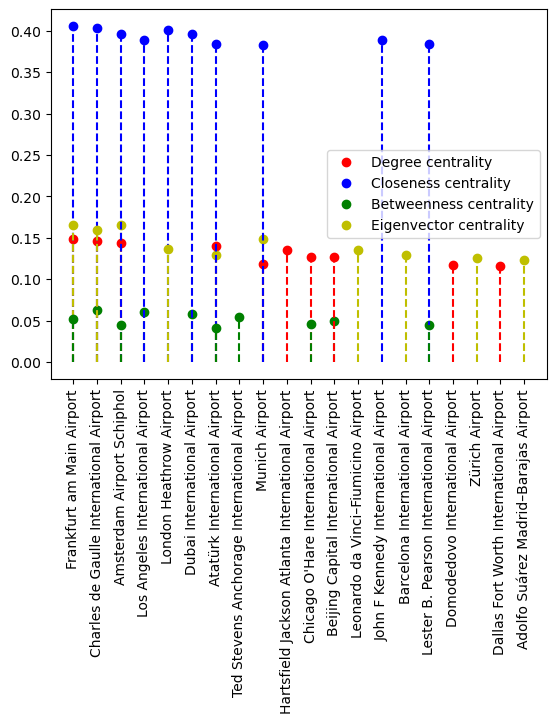

In [42]:
# for every airport in the most important airports, plot the centrality measures
for j in range(10):
    plt.plot(airport_dict[ten_highest_degree_centralities[j][0]], ten_highest_degree_centralities[j][1], 'ro')
    plt.plot(airport_dict[ten_highest_closeness_centralities[j][0]], ten_highest_closeness_centralities[j][1], 'bo')
    plt.plot(airport_dict[ten_highest_betweenness_centralities[j][0]], ten_highest_betweenness_centralities[j][1], 'go')
    plt.plot(airport_dict[ten_highest_eigenvector_centralities[j][0]], ten_highest_eigenvector_centralities[j][1], 'yo')

    # plot perpendicular lines to the x-axis
    plt.plot([airport_dict[ten_highest_degree_centralities[j][0]], airport_dict[ten_highest_degree_centralities[j][0]]], [0, ten_highest_degree_centralities[j][1]], 'r--')
    plt.plot([airport_dict[ten_highest_closeness_centralities[j][0]], airport_dict[ten_highest_closeness_centralities[j][0]]], [0, ten_highest_closeness_centralities[j][1]], 'b--')
    plt.plot([airport_dict[ten_highest_betweenness_centralities[j][0]], airport_dict[ten_highest_betweenness_centralities[j][0]]], [0, ten_highest_betweenness_centralities[j][1]], 'g--')
    plt.plot([airport_dict[ten_highest_eigenvector_centralities[j][0]], airport_dict[ten_highest_eigenvector_centralities[j][0]]], [0, ten_highest_eigenvector_centralities[j][1]], 'y--')
plt.legend(['Degree centrality', 'Closeness centrality', 'Betweenness centrality', 'Eigenvector centrality'])
plt.xticks(rotation=90)
plt.show()
   


We can now identify the airports which have the highest centrality measures in all 4 kind of centrality measure. This are the airports:

* Frankfurt am Main Airport
* Charles de Gaulle International Airport
* Amsterdam Airport Schiphol
* Atatürk International Airport

Of high interest is, that they all appear also in the two lists of the in-degree and out-degree distributions.

## The most important airports in terms of Page Rank
PageRank
* is developed by Larry page from Google to rank the likelihood of someone visiting a webpage.
* We interpret it as the disease traveling to airports. Therefore, the numbers can be interpreted as the likelihood of a disease reaching an airport. Reasearch has suggested that nodes with high PageRank values are more likely to be super-spreaders of a disese. https://digitalcommons.calpoly.edu/cgi/viewcontent.cgi?article=3904&context=theses

* is the weighted sum over PageRanks of its backlinks
* An airport has a high rank if the sum of the ranks fo the airports that link to it is high
* Backlink prediction 

In the page rank calculation of Larry Page a higher damping factor implies that a random surfer follows links with higher probability. And also avoids pages with a lower probability. If alpha is large it increases the iterations needed. And using a smaller alpha decreases the iterations needed.
The damping parameter alpha could be the spreading parameter. Therefore we try different values for alpha. 

If alpha is high (> 0.85) the disease is less contagious so the disease follows only links which have a higher probability, namely the routs with a high weight.
If alpha is small (≤ 0.85) the disease is more contagious and follows also links with a smaller probability, namely the routs with a lower weight.


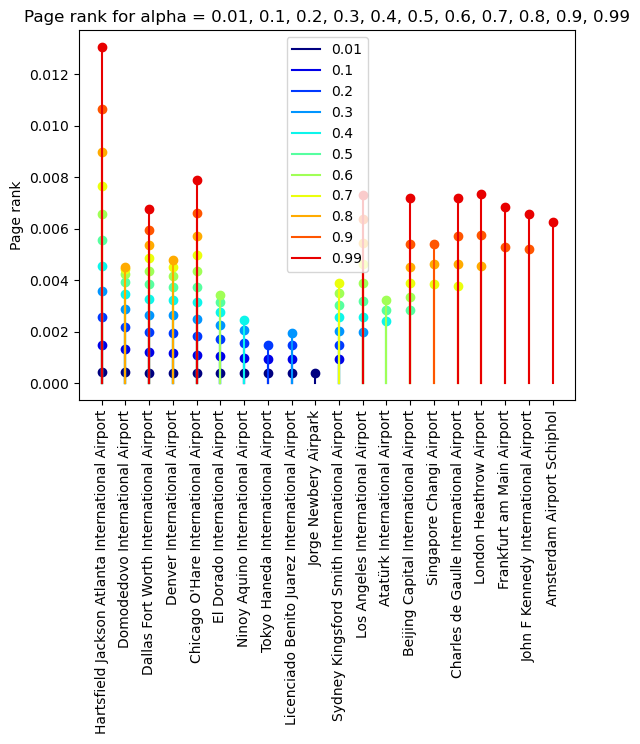

In [21]:
alphas = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
pageRanks = []
for alpha in alphas:
    pageRanks.append(nx.pagerank(G, alpha=alpha))

#assign different plot colors to the different alpha values
colors = []
for i in range (len(alphas)):
    colors.append(plt.cm.jet(i/len(alphas)))
# for each alpha, plot the 10 airports with the highest page rank
for i, alpha in enumerate(alphas):
    ten_highest_page_ranks = sorted(pageRanks[i].items(), key=lambda x: x[1], reverse=True)[:10]
    for j in range(10):
        plt.plot(airport_dict[ten_highest_page_ranks[j][0]], ten_highest_page_ranks[j][1], 'o', color=colors[i])
        # plot perpendicular lines to the x-axis at the best airports
        plt.plot([airport_dict[ten_highest_page_ranks[j][0]], airport_dict[ten_highest_page_ranks[j][0]]], [0, ten_highest_page_ranks[j][1]], color=colors[i], label= alphas[i] if j == 0 else "")
   
plt.ylabel('Page rank')
plt.legend()
plt.xticks(rotation=90)
plt.title('Page rank for alpha = 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99')
plt.show()

When we compare the pageranks of the airports then do we have 3 Airports which are with every value for alpha between 0.01 and 0.99 in the 20 airports with the highest page rank:
* Hartsfield Jackson Atlanta International Airport
* Dallas Fort Worth International Airport
* Chicago O' Hare International Airport


What is even of more interest, is that the 4 airports which were under the most important 10 airports with respect to each centrality measure are now also under the airports with the highest page ranks:
* Frankfurt am Main Airport with an alpha between 0.9 and 0.99
* Charles de Gaulle International Airport with an alpha between 0.7 and 0.99
* Amsterdam Airport Schiphol with an alpha of 0.99
* Atatürk International Airport with an alpha between 0.4 and 0.6



# Analysing the Undirected Graph GU

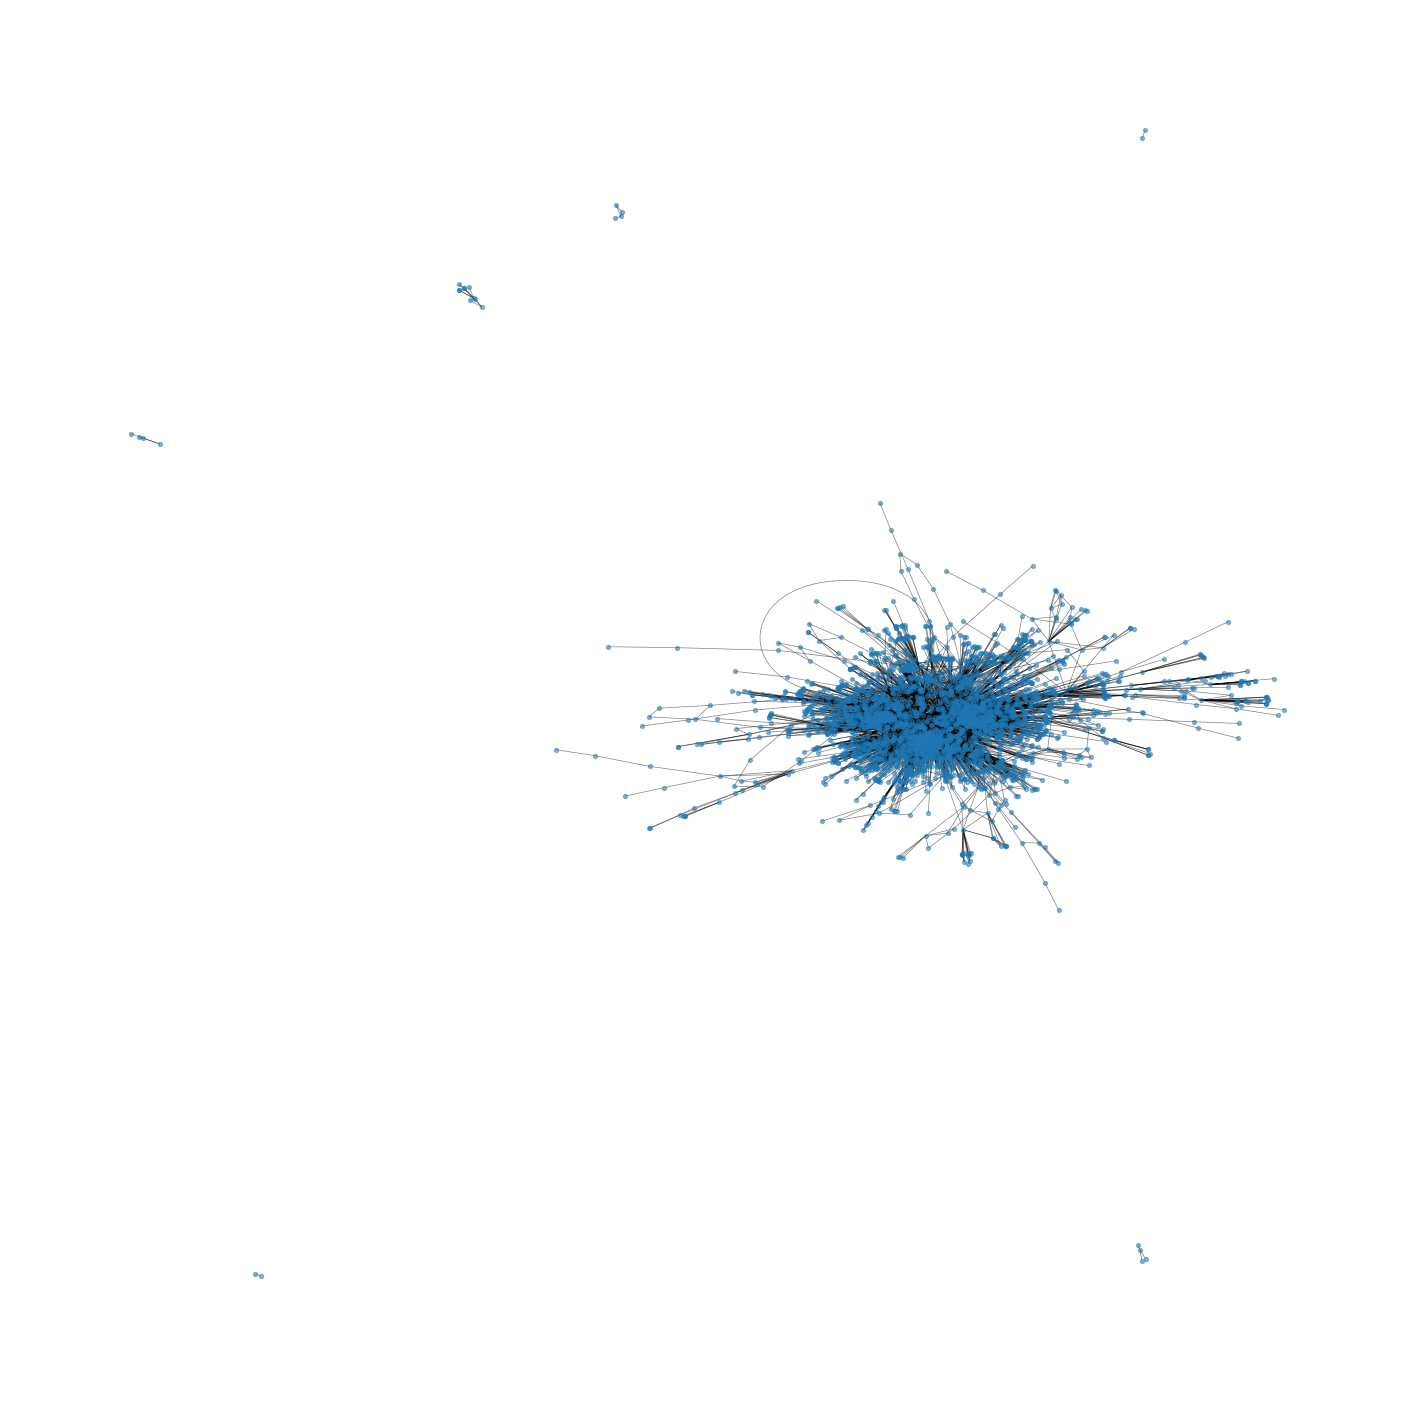

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(18, 18))
nx.draw_networkx(GU, ax=ax, node_size=8, alpha=.5,
                 width=.5, with_labels=False)
ax.set_axis_off()

#### Analysis of the undirected graph

In [23]:
# Basic calculations
degree = nx.degree(GU)
degree_hist = nx.degree_histogram(GU)
density = nx.density(GU)
average_clustering = nx.average_clustering(GU)
num_nodes = nx.number_of_nodes(GU)
num_edges = nx.number_of_edges(GU)
num_connected_components = nx.number_connected_components(GU)
average_degree = sum(degree_hist) / len(degree_hist)
max_weight = max([GU[u][v]['weight'] for u,v in GU.edges()])

In [24]:
print("Undirected graph")
print("------------------------------------------------------")
print(f"Density:                          {density}")
print(f"Average clustering                {average_clustering}")
print(f"Number of nodes:                  {num_nodes}")
print(f"Number of edges:                  {num_edges}")
print(f"Number of connected components:   {num_connected_components}")
print(f"Average degree:                   {average_degree}")
print(f"Max weight:                       {max_weight}")

Undirected graph
------------------------------------------------------
Density:                          0.0036525154208817594
Average clustering                0.4917731731380378
Number of nodes:                  3214
Number of edges:                  18859
Number of connected components:   7
Average degree:                   12.907630522088354
Max weight:                       39


Max weight edge

In [25]:
# 1885, 1809, distance, 3378, 1, E75 CR7, 0
max_edge = max(dict(GU.edges).items(), key=lambda x: x[1]['weight'])
source_airport = airport_dict[max_edge[0][0]]
target_airport = airport_dict[max_edge[0][1]]
flights = max_edge[1]['weight']

print("The most popular route is from {} to {} with {} flights".format(source_airport, target_airport, flights))


The most popular route is from Hartsfield Jackson Atlanta International Airport to Chicago O'Hare International Airport with 39 flights


In [26]:
# 1885, 1809, distance, 3378, 1, E75 CR7, 0
print("The most popular routes are:")
max_edge = sorted(dict(GU.edges).items(), key=lambda x: x[1]['weight'], reverse=True)
for i in range(10):
    source_airport = airport_dict[max_edge[i][0][0]]
    target_airport = airport_dict[max_edge[i][0][1]]
    flights = max_edge[i][1]['weight']

    print("{}. From {} to {} with {} flights".format(i+1,source_airport, target_airport, flights))

The most popular routes are:
1. From Hartsfield Jackson Atlanta International Airport to Chicago O'Hare International Airport with 39 flights
2. From London Heathrow Airport to John F Kennedy International Airport with 24 flights
3. From Hong Kong International Airport to Suvarnabhumi Airport with 24 flights
4. From Miami International Airport to Hartsfield Jackson Atlanta International Airport with 24 flights
5. From Abu Dhabi International Airport to Muscat International Airport with 23 flights
6. From Phuket International Airport to Suvarnabhumi Airport with 23 flights
7. From London Heathrow Airport to Los Angeles International Airport with 22 flights
8. From Charles de Gaulle International Airport to John F Kennedy International Airport with 22 flights
9. From Bahrain International Airport to Hamad International Airport with 22 flights
10. From Guangzhou Baiyun International Airport to Hangzhou Xiaoshan International Airport with 22 flights


# Map

Did not work out as expected, but please do not remove it since it could be helpful

In [27]:
"""
df = pd.read_csv('nodes.csv')
df.columns = [c.replace(' ', '') for c in df.columns]
pos = {airport: (df.longitude, df.latitude) for airport, df in df.iterrows()}
"""

"\ndf = pd.read_csv('nodes.csv')\ndf.columns = [c.replace(' ', '') for c in df.columns]\npos = {airport: (df.longitude, df.latitude) for airport, df in df.iterrows()}\n"

In [28]:
"""
largest_cc = list(GU.subgraph(c) for c in nx.connected_components(GU))[0]
print(largest_cc)
deg = nx.degree(largest_cc)
sizes = [5 * deg[iata] for iata in largest_cc.nodes]
"""

'\nlargest_cc = list(GU.subgraph(c) for c in nx.connected_components(GU))[0]\nprint(largest_cc)\ndeg = nx.degree(largest_cc)\nsizes = [5 * deg[iata] for iata in largest_cc.nodes]\n'

In [29]:
"""
def display_map(graph, node_color=None):
    # Map projection
    fig, ax = plt.subplots(
        1, 1, figsize=(36, 24),
        subplot_kw=dict(projection=ccrs.PlateCarree()))
    ax.coastlines()

    # Extent of continental US.
    #ax.set_extent([-128, -62, 20, 50])
    nx.draw_networkx(graph, ax=ax,
                     font_size=20,
                     alpha=.5,
                     width=.075,
                     node_size=sizes,
                     #labels=labels,
                     pos=pos,
                     node_color=node_color)
"""

'\ndef display_map(graph, node_color=None):\n    # Map projection\n    fig, ax = plt.subplots(\n        1, 1, figsize=(36, 24),\n        subplot_kw=dict(projection=ccrs.PlateCarree()))\n    ax.coastlines()\n\n    # Extent of continental US.\n    #ax.set_extent([-128, -62, 20, 50])\n    nx.draw_networkx(graph, ax=ax,\n                     font_size=20,\n                     alpha=.5,\n                     width=.075,\n                     node_size=sizes,\n                     #labels=labels,\n                     pos=pos,\n                     node_color=node_color)\n'

In [30]:
"""
display_map(largest_cc)
"""

'\ndisplay_map(largest_cc)\n'

In [31]:
"""
df = pd.read_csv('nodes.csv')
#print(df.keys())
df.columns = [c.replace(' ', '') for c in df.columns]
#print(df.keys())

geometry = [Point(latitudelongitude) for latitudelongitude in zip(df.latitude, df.longitude)]
#crs = {'init': 'epsg:2263'} #http://www.spatialreference.org/ref/epsg/2263/
#geo_df = geopandas.GeoDataFrame(df, crs=crs, geometry=geometry)

#geo_df.to_file(driver='ESRI Shapefile', filename='data.shp')

#print(geometry)
"""

"\ndf = pd.read_csv('nodes.csv')\n#print(df.keys())\ndf.columns = [c.replace(' ', '') for c in df.columns]\n#print(df.keys())\n\ngeometry = [Point(latitudelongitude) for latitudelongitude in zip(df.latitude, df.longitude)]\n#crs = {'init': 'epsg:2263'} #http://www.spatialreference.org/ref/epsg/2263/\n#geo_df = geopandas.GeoDataFrame(df, crs=crs, geometry=geometry)\n\n#geo_df.to_file(driver='ESRI Shapefile', filename='data.shp')\n\n#print(geometry)\n"

In [32]:
"""
# https://networkx.org/documentation/stable/auto_examples/geospatial/plot_delaunay.html
df = pd.read_csv('nodes.csv')
print(df.head())
df.columns = [c.replace(' ', '') for c in df.columns]
coordinates = np.column_stack((df.latitude, df.longitude))
cells, generators = voronoi_frames(coordinates, clip=None)
#cells, generators = voronoi_frames(coordinates, clip="convex hull")
delaunay = weights.Rook.from_dataframe(cells)
delaunay_graph = delaunay.to_networkx()
positions = dict(zip(delaunay_graph.nodes, coordinates))
ax = cells.plot(facecolor="lightblue", alpha=0.10, edgecolor="cornsilk", linewidth=1)
add_basemap(ax, source="world.tif") #hereee!!!!
ax.axis("off")
nx.draw(
    delaunay_graph,
    positions,
    ax=ax,
    node_size=2,
    node_color="k",
    edge_color="k",
    alpha=0.8,
)
plt.show()
"""


'\n# https://networkx.org/documentation/stable/auto_examples/geospatial/plot_delaunay.html\ndf = pd.read_csv(\'nodes.csv\')\nprint(df.head())\ndf.columns = [c.replace(\' \', \'\') for c in df.columns]\ncoordinates = np.column_stack((df.latitude, df.longitude))\ncells, generators = voronoi_frames(coordinates, clip=None)\n#cells, generators = voronoi_frames(coordinates, clip="convex hull")\ndelaunay = weights.Rook.from_dataframe(cells)\ndelaunay_graph = delaunay.to_networkx()\npositions = dict(zip(delaunay_graph.nodes, coordinates))\nax = cells.plot(facecolor="lightblue", alpha=0.10, edgecolor="cornsilk", linewidth=1)\nadd_basemap(ax, source="world.tif") #hereee!!!!\nax.axis("off")\nnx.draw(\n    delaunay_graph,\n    positions,\n    ax=ax,\n    node_size=2,\n    node_color="k",\n    edge_color="k",\n    alpha=0.8,\n)\nplt.show()\n'

In [33]:
"""
# read in example data from a geopackage file. Geopackages
# are a format for storing geographic data that is backed
# by sqlite. geopandas reads data relying on the fiona package,
# providing a high-level pandas-style interface to geographic data.
cases = geopandas.read_file("cholera_cases.gpkg")

# construct the array of coordinates for the centroid
coordinates = np.column_stack((cases.geometry.x, cases.geometry.y))

# construct two different kinds of graphs:

## 3-nearest neighbor graph, meaning that points are connected
## to the three closest other points. This means every point
## will have exactly three neighbors.
knn3 = weights.KNN.from_dataframe(df, k=3)
print(cases)

## The 50-meter distance band graph will connect all pairs of points
## that are within 50 meters from one another. This means that points
## may have different numbers of neighbors.
dist = weights.DistanceBand.from_array(coordinates, threshold=50)

# Then, we can convert the graph to networkx object using the
# .to_networkx() method.
knn_graph = knn3.to_networkx()
dist_graph = dist.to_networkx()

# To plot with networkx, we need to merge the nodes back to
# their positions in order to plot in networkx
positions = dict(zip(knn_graph.nodes, coordinates))

# plot with a nice basemap
f, ax = plt.subplots(1, 2, figsize=(8, 4))
for i, facet in enumerate(ax):
    cases.plot(marker=".", color="orangered", ax=facet)
    add_basemap(facet)
    facet.set_title(("KNN-3", "50-meter Distance Band")[i])
    facet.axis("off")
nx.draw(knn_graph, positions, ax=ax[0], node_size=5, node_color="b")
nx.draw(dist_graph, positions, ax=ax[1], node_size=5, node_color="b")
plt.show()
"""

'\n# read in example data from a geopackage file. Geopackages\n# are a format for storing geographic data that is backed\n# by sqlite. geopandas reads data relying on the fiona package,\n# providing a high-level pandas-style interface to geographic data.\ncases = geopandas.read_file("cholera_cases.gpkg")\n\n# construct the array of coordinates for the centroid\ncoordinates = np.column_stack((cases.geometry.x, cases.geometry.y))\n\n# construct two different kinds of graphs:\n\n## 3-nearest neighbor graph, meaning that points are connected\n## to the three closest other points. This means every point\n## will have exactly three neighbors.\nknn3 = weights.KNN.from_dataframe(df, k=3)\nprint(cases)\n\n## The 50-meter distance band graph will connect all pairs of points\n## that are within 50 meters from one another. This means that points\n## may have different numbers of neighbors.\ndist = weights.DistanceBand.from_array(coordinates, threshold=50)\n\n# Then, we can convert the graph to net